In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean, cityblock
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from scipy.optimize import curve_fit

raw = pd.read_csv('METABRIC_RNA_Mutation.csv', low_memory=False)

In [89]:
def pre_process(df):
    """Performs all pre-processing steps including imputation, mapping and
    log-transformation."""
    
    df = raw[raw['death_from_cancer'] != 
             'Died of Other Causes'].iloc[:, :515].copy()                           ## remove patients died from other causes
    df.drop(columns=['death_from_cancer'], inplace=True)

    ## remove irrelevant and redundant features
    df.drop(columns=['patient_id', 'cancer_type', 
                     'er_status_measured_by_ihc', 'her2_status'], inplace=True)

    ## map cellularity
    cellularity_map = {'High': 3, 'Moderate': 2, 'Low': 1}
    df['cellularity'] = df['cellularity'].map(cellularity_map)

    ## impute missing values
    df['neoplasm_histologic_grade'].fillna(
        df['neoplasm_histologic_grade'].value_counts().index[0], inplace=True)     ## most frequent
    df['mutation_count'].fillna(df['mutation_count'].value_counts().index[0],
                                inplace=True)
    df['tumor_size'].fillna(df['tumor_size'].mean(), inplace=True)                 ## mean
    df['tumor_stage'].fillna(df['tumor_stage'].value_counts().index[0], 
                             inplace=True)
    df['cellularity'].fillna(df['cellularity'].value_counts().index[0], 
                             inplace=True)

    ## handing of wrong entries
    df = df.replace('Breast', df['cancer_type_detailed'].value_counts().index[0])

    ## logarithmic transformation of continuous numerical features
    df['log_age'] = (df['age_at_diagnosis']+1).transform(np.log)
    df['log_tumor_size'] = (df['tumor_size']+1).transform(np.log)

    df.drop(columns=['age_at_diagnosis', 'tumor_size'], inplace=True)
    return df

def discretize_transform(df):
    """Discretized df into time intervals.
    """
    def discretize(x):
        return np.ceil(x/12)
    
    df['time_bin'] = df['overall_survival_months'].apply(lambda x: discretize(x))
    
    return df

In [90]:
df = pre_process(raw)

In [165]:
df = df[df['overall_survival_months'] <= 60].copy()

In [166]:
# df_t2 = df[df[f'time_bin']==2].drop(columns='time_bin')
# df_t3 = df[df[f'time_bin']==3].drop(columns='time_bin')
# df_t4 = df[df[f'time_bin']==4].drop(columns='time_bin')
# df_t5 = df[df[f'time_bin']==5].drop(columns='time_bin')
# df_t6 = df[df[f'time_bin']==6].drop(columns='time_bin')
# df_t7 = df[df[f'time_bin']==7].drop(columns='time_bin')
# df_t8 = df[df[f'time_bin']==8].drop(columns='time_bin')
# df_t9 = df[df[f'time_bin']==9].drop(columns='time_bin')

In [82]:
df_t5['overall_survival'].value_counts()

0    65
1    15
Name: overall_survival, dtype: int64

In [167]:
## check and filter collinearities among features

s_list = [0]

while len(s_list):
    corr = df.iloc[:100].corr()
    col_list2 = corr.columns
    series_dict = {}
    for col in col_list2:
        x = corr.sort_values(by=col, ascending=False)[col].iloc[1:2]
        if x.values > 0.6:
            series_dict[col] = x.index[0]

    unique = set(series_dict.keys()) -set(series_dict.values())
    duplicates = set(series_dict.keys()) -  unique
    
    m = []
    for dup in duplicates:
         if dup not in m:
                m.append(series_dict[dup])
    s_list = m + list(unique)

    df.drop(columns=s_list, inplace=True)
#     df_t3.drop(columns=s_list, inplace=True)
#     df_t4.drop(columns=s_list, inplace=True)
#     df_t5.drop(columns=s_list, inplace=True)
#     df_t6.drop(columns=s_list, inplace=True)
#     df_t7.drop(columns=s_list, inplace=True)
#     df_t8.drop(columns=s_list, inplace=True)
#     df_t9.drop(columns=s_list, inplace=True)

In [168]:
df

,type_of_breast_surgery,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status,her2_status_measured_by_snp6,tumor_other_histologic_subtype,hormone_therapy,...,serpini1,shbg,slc29a1,sox9,srd5a1,srd5a2,st7,star,log_age,log_tumor_size
4,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,3.0,1,LumB,1.0,Positive,NEUTRAL,Mixed,1,...,-0.5545,0.0266,0.5328,0.1858,-0.5845,-0.3544,2.2961,0.1817,4.356324,3.713572
5,MASTECTOMY,Breast Invasive Ductal Carcinoma,2.0,0,LumB,1.0,Positive,NEUTRAL,Ductal/NST,1,...,-0.3843,0.4306,0.0314,0.6884,-0.3910,0.0395,0.1977,-0.2302,4.379147,3.465736
9,MASTECTOMY,Breast Invasive Lobular Carcinoma,3.0,0,Her2,1.0,Positive,LOSS,Lobular,0,...,-0.7730,-0.0610,-0.7246,0.2232,-0.3020,-0.4788,1.9925,0.2253,4.445236,3.367296
24,MASTECTOMY,Breast Invasive Ductal Carcinoma,3.0,1,Her2,1.0,Negative,NEUTRAL,Ductal/NST,0,...,-0.4717,-0.2999,-1.1837,-0.6720,0.5388,0.7492,2.6880,-0.0811,3.940027,3.713572
30,MASTECTOMY,Breast Invasive Ductal Carcinoma,1.0,1,Basal,1.0,Negative,NEUTRAL,Ductal/NST,0,...,-0.8543,-0.6889,0.5904,-0.4976,-0.9430,1.0138,0.0830,0.2368,4.243913,3.688879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1887,MASTECTOMY,Breast Invasive Ductal Carcinoma,2.0,1,Her2,4.0,Negative,GAIN,Ductal/NST,1,...,-0.7585,0.6265,0.2031,-0.7843,0.4139,3.1679,-0.6758,-0.9143,3.955466,2.833213
1888,BREAST CONSERVING,Breast Invasive Lobular Carcinoma,2.0,1,LumB,4.0,Positive,LOSS,Lobular,1,...,2.4943,-0.5515,0.3960,0.9873,0.6775,0.2300,0.8643,-1.5209,4.014941,3.433987
1893,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,3.0,0,LumB,4.0,Positive,NEUTRAL,Ductal/NST,1,...,-0.1345,-0.7049,-0.1228,0.1102,-0.3262,0.7857,0.9358,-0.9700,4.037774,3.433987
1895,MASTECTOMY,Breast Invasive Ductal Carcinoma,3.0,0,claudin-low,4.0,Negative,GAIN,Ductal/NST,1,...,-0.5185,-0.7966,-1.2708,-0.5444,-0.1952,-1.4212,-0.2010,-0.3020,4.004967,3.931826


In [164]:
## one-hot encode nominal features 

X_t2 = pd.get_dummies(df.drop(columns=['overall_survival']))
y_t2 = df['overall_survival']

# X_t3 = pd.get_dummies(df_t3.drop(columns=['overall_survival', 'overall_survival_months']))
# y_t3 = df_t3['overall_survival']

# X_t4 = pd.get_dummies(df_t4.drop(columns=['overall_survival', 'overall_survival_months']))
# y_t4 = df_t4['overall_survival']

# X_t5 = pd.get_dummies(df_t5.drop(columns=['overall_survival', 'overall_survival_months']))
# y_t5 = df_t5['overall_survival']

# X_t6 = pd.get_dummies(df_t6.drop(columns=['overall_survival', 'overall_survival_months']))
# y_t6 = df_t6['overall_survival']

# X_t7 = pd.get_dummies(df_t7.drop(columns=['overall_survival', 'overall_survival_months']))
# y_t7 = df_t7['overall_survival']

# X_t8 = pd.get_dummies(df_t8.drop(columns=['overall_survival', 'overall_survival_months']))
# y_t8 = df_t8['overall_survival']

# X_t9 = pd.get_dummies(df_t9.drop(columns=['overall_survival', 'overall_survival_months']))
# y_t9 = df_t9['overall_survival']

In [169]:
## dimensionality reduction by Singuar Value Decomposition

def truncated_svd(X):
    '''Reduce dimensionality of TFIDF Matrix.'''
    q, s, p = np.linalg.svd(X)
    return q, np.diag(s), p.T, s**2/np.linalg.norm(s**2, 1)

q, s, p, nssd = [], [], [], []

X = [X_t2]

for x in X:
    qx, sx, px, nssdx = truncated_svd(x)
    q.append(qx)
    s.append(sx)
    p.append(px)
    nssd.append(nssdx)

In [171]:
# np.where(np.round(nssd[0].cumsum(), 1) == 0.9 )[0][1]
# nssd[6].cumsum()
# nssd[0].cumsum()

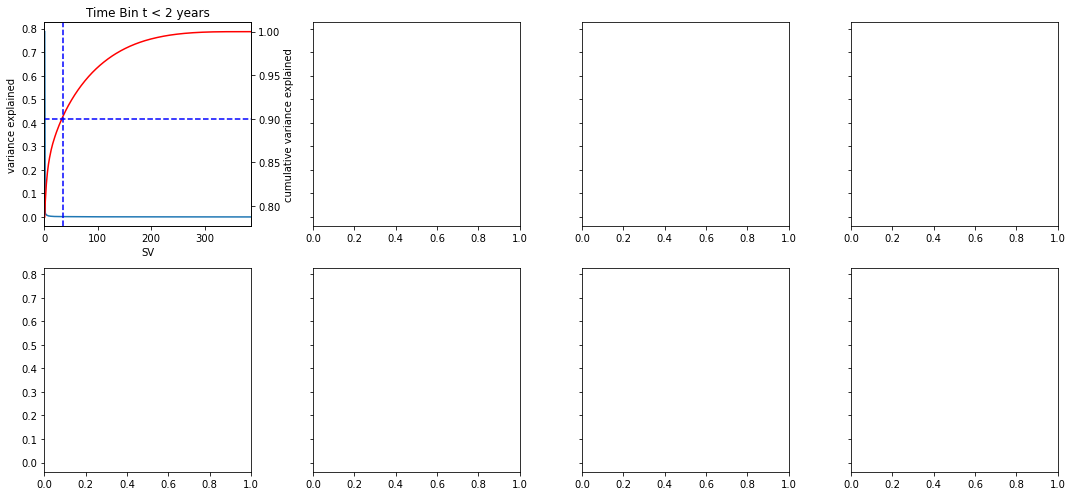

In [178]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(15,7), sharey=True)

ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

svs = [35]

for i in range(1):
    ax_list[i].plot(range(1, len(nssd[i])+1), nssd[i], '-', label='individual')
    ax_list[i].set_xlim(0, len(nssd[i])+1)
    ax_list[i].set_xlabel('SV')
    ax_list[i].set_ylabel('variance explained')
    ax_list[i] = ax_list[i].twinx()
    ax_list[i].plot(range(1, len(nssd[i])+1), nssd[i].cumsum(), 'r-', label='cumulative')
    ax_list[i].axhline(0.9, ls='--', color='b')
    ax_list[i].set_ylabel('cumulative variance explained')
    ax_list[i].axvline(svs[i], ls='--', color='b')
    ax_list[i].set_title(f'Time Bin t < {i+2} years')

plt.tight_layout();

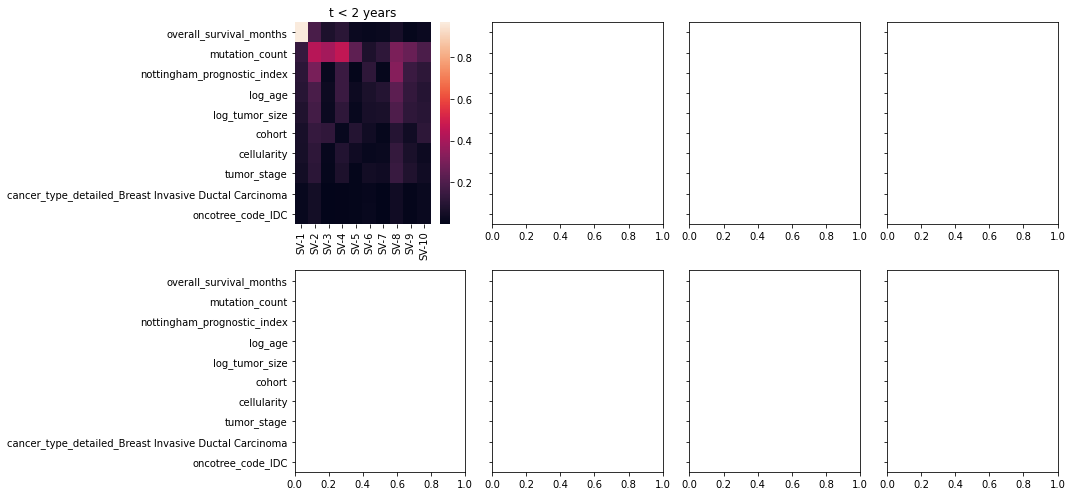

In [179]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(15,7), sharey=True)

ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
X_reduced = []

for i in range(1):
    svd = TruncatedSVD(n_components=svs[i]).fit(X[i])
    X_reduced.append(svd.transform(X[i]))
    I = np.identity(X[i].shape[1])
    weights = pd.DataFrame(svd.transform(I), index=X[i].columns)
    weights.columns = [f'SV-{i+1}' for i in weights.columns]
    weights = weights.transform(np.abs).copy()
    sns.heatmap(weights.sort_values(by='SV-1', ascending=False).iloc[:10, :10], 
                ax=ax_list[i])
    ax_list[i].set_title(f't < {i+2} years')

plt.tight_layout()

In [117]:
X_reduced[0].shape
y_t2.shape

(1424,)

In [180]:
## run logistic regression classifier

logic_t2 = LogisticRegressionCV(Cs=[0.0001, 0.0015, 0.002, 0.003, 0.004, 0.0045], 
                                cv=20, scoring='roc_auc', penalty='l2', 
                             solver='liblinear', max_iter=1000, n_jobs=-1
                               ).fit(X_reduced[0], y_t2)
prob_t2 = pd.DataFrame(logic_t2.predict_proba(X_reduced[0]))
prob_t2['actual'] = list(y_t2)
prob_t2['pred'] = logic_t2.predict(X_reduced[0])

mean_t2, std_t2 = np.mean(logic_t2.scores_[1]), np.std(logic_t2.scores_[1])


# logic_t3 = LogisticRegressionCV(Cs=[0.0001, 0.0015, 0.002, 0.003, 0.004, 0.0045], 
#                                 cv=20, scoring='roc_auc', penalty='l2', 
#                              solver='liblinear', max_iter=1000, n_jobs=-1
#                                ).fit(X_reduced[1], y_t3)
# prob_t3 = pd.DataFrame(logic_t3.predict_proba(X_reduced[1]))
# prob_t3['actual'] = list(y_t3)
# prob_t3['pred'] = logic_t3.predict(X_reduced[1])
# mean_t3, std_t3 = np.mean(logic_t3.scores_[1]), np.std(logic_t3.scores_[1])


# logic_t4 = LogisticRegressionCV(Cs=[0.0001, 0.0015, 0.002, 0.003, 0.004, 0.0045],
#                                 cv=20, scoring='roc_auc', penalty='l2', 
#                              solver='liblinear', max_iter=1000, n_jobs=-1
#                                ).fit(X_reduced[2], y_t4)
# prob_t4 = pd.DataFrame(logic_t4.predict_proba(X_reduced[2]))
# prob_t4['actual'] = list(y_t4)
# prob_t4['pred'] = logic_t4.predict(X_reduced[2])
# mean_t4, std_t4 = np.mean(logic_t4.scores_[1]), np.std(logic_t4.scores_[1])


# logic_t5 = LogisticRegressionCV(Cs=[0.0001, 0.0015, 0.002, 0.003, 0.004, 0.0045],
#                                 cv=20, scoring='roc_auc', penalty='l2', 
#                              solver='liblinear', max_iter=1000, n_jobs=-1
#                                ).fit(X_reduced[3], y_t5)
# prob_t5 = pd.DataFrame(logic_t5.predict_proba(X_reduced[3]))
# prob_t5['actual'] = list(y_t5)
# prob_t5['pred'] = logic_t5.predict(X_reduced[3])
# mean_t5, std_t5 = np.mean(logic_t5.scores_[1]), np.std(logic_t5.scores_[1])


# logic_t6 = LogisticRegressionCV(Cs=[0.0001, 0.0015, 0.002, 0.003, 0.004, 0.0045],
#                                 cv=20, scoring='roc_auc', penalty='l2', 
#                              solver='liblinear', max_iter=1000, n_jobs=-1
#                                ).fit(X_reduced[4], y_t6)
# prob_t6 = pd.DataFrame(logic_t6.predict_proba(X_reduced[4]))
# prob_t6['actual'] = list(y_t6)
# prob_t6['pred'] = logic_t6.predict(X_reduced[4])
# mean_t6, std_t6 = np.mean(logic_t6.scores_[1]), np.std(logic_t6.scores_[1])


# logic_t7 = LogisticRegressionCV(Cs=[0.0001, 0.0015, 0.002, 0.003, 0.004, 0.0045],
#                                 cv=20, scoring='roc_auc', penalty='l2', 
#                              solver='liblinear', max_iter=1000, n_jobs=-1
#                                ).fit(X_reduced[5], y_t7)
# prob_t7 = pd.DataFrame(logic_t7.predict_proba(X_reduced[5]))
# prob_t7['actual'] = list(y_t7)
# prob_t7['pred'] = logic_t7.predict(X_reduced[5])
# mean_t7, std_t7 = np.mean(logic_t7.scores_[1]), np.std(logic_t7.scores_[1])


# logic_t8 = LogisticRegressionCV(Cs=[0.0001, 0.0015, 0.002, 0.003, 0.004, 0.0045],
#                                 cv=20, scoring='roc_auc', penalty='l2', 
#                              solver='liblinear', max_iter=1000, n_jobs=-1
#                                ).fit(X_reduced[6], y_t8)
# prob_t8 = pd.DataFrame(logic_t8.predict_proba(X_reduced[6]))
# prob_t8['actual'] = list(y_t8)
# prob_t8['pred'] = logic_t8.predict(X_reduced[6])
# mean_t8, std_t8 = np.mean(logic_t8.scores_[1]), np.std(logic_t8.scores_[1])


# logic_t9 = LogisticRegressionCV(Cs=[0.0001, 0.0015, 0.002, 0.003, 0.004, 0.0045],
#                                 cv=20, scoring='roc_auc', penalty='l2', 
#                              solver='liblinear', max_iter=1000, n_jobs=-1
#                                ).fit(X_reduced[7], y_t9)
# prob_t9 = pd.DataFrame(logic_t9.predict_proba(X_reduced[7]))
# prob_t9['actual'] = list(y_t9)
# prob_t9['pred'] = logic_t9.predict(X_reduced[7])
# mean_t9, std_t9 = np.mean(logic_t9.scores_[1]), np.std(logic_t9.scores_[1])

In [181]:
results = pd.concat([X_t2, 
                        prob_t2.set_index(X_t2.index)], axis=1)

In [198]:
sum(results['actual'] == 1)
# mean_t2

60

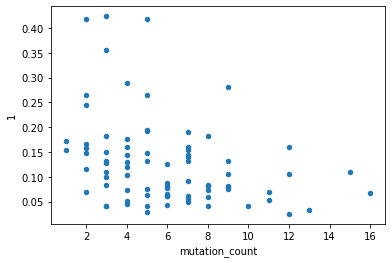

In [207]:
dt = discretize_transform(results)

dt[dt['time_bin'] == 5][[1, 'mutation_count']].plot(kind='scatter', x='mutation_count', y=1)

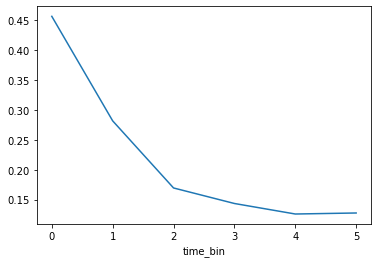

In [216]:
dt.groupby('time_bin')[1].mean().plot(kind='line')